In [11]:
from setup import *
from utils import *

In [12]:
# Optimization params
spp = 16
iterations = 100
exp = 1/3

# Determine the orthonormal basis for this camera viewport
w = normalize(np.array([0.1913462, 0.33140403, -0.92388207]))
up = normalize(np.array([0.0,-1.0,0.0]))
u = np.cross(up, w)
v = np.cross(w, u)

# Convert to mitsuba vectors
u = mi.cuda_ad_rgb.Vector3f(u)
v = mi.cuda_ad_rgb.Vector3f(v)
w = mi.cuda_ad_rgb.Vector3f(w)
print(u, v, w)

# Set up the scene
materials = create_materials(with_fluids=False)
components = load_components(materials=materials)
components.pop('viewports_outer') # remove the viewports so the rays do not get blocked by them
components.pop('viewports_inner')

film = {
    'type': 'hdrfilm',
    'rfilter': {
        'type': 'gaussian'
    },
    'width': 1280,
    'height': 800,
    'sample_border': True
}
sampler = {
    'type': 'independent',
    'sample_count': 4*spp # render with max spp of our optimization process
}
sensor = create_sensor(sensor_number=2, film=film, sampler=sampler)

integrator = {'type': 'direct_projective'}
# integrator = {'type': 'prb_projective', 'max_depth': 4}
scene = load_scene(components=components, sensor=sensor, integrator=integrator)

# Create reference image -- select only red channel
image_ref = render(scene=scene, denoise=False)[:,:,0]**exp
mi.Bitmap(image_ref)

[[0.923882007598877, 0.0, 0.1913461983203888]] [[0.06341289728879929, -0.8901713490486145, -0.3061782121658325]] [[0.1913461983203888, 0.33140403032302856, -0.923882007598877]]


Bitmap[
  pixel_format = y,
  component_format = float32,
  size = [1280, 800],
  srgb_gamma = 0,
  struct = Struct<4>[
    float32 Y; // @0, premultiplied alpha
  ],
  data = [ 3.91 MiB of image data ]
]

In [13]:
threshold = 0.3
mi.Bitmap(dr.select(image_ref>threshold, image_ref, 0))

Bitmap[
  pixel_format = y,
  component_format = float32,
  size = [1280, 800],
  srgb_gamma = 0,
  struct = Struct<4>[
    float32 Y; // @0, premultiplied alpha
  ],
  data = [ 3.91 MiB of image data ]
]

In [14]:
scene_params = mi.traverse(scene)
scene_params

SceneParameters[
  ------------------------------------------------------------------------------------------------------------
  Name                                                     Flags    Type           Parent
  ------------------------------------------------------------------------------------------------------------
  cables.bsdf.eta.value                                    ∂, D     Color3f        SRGBReflectanceSpectrum
  cables.bsdf.k.value                                      ∂, D     Color3f        SRGBReflectanceSpectrum
  cables.bsdf.specular_reflectance.value                   ∂        Float          UniformSpectrum
  cables.silhouette_sampling_weight                                 float          PLYMesh
  cables.faces                                                      UInt           PLYMesh
  cables.vertex_positions                                  ∂, D     Float          PLYMesh
  cables.vertex_normals                                    ∂, D     Float          PL

In [15]:
param_key = 'sensor.to_world'
dr.enable_grad(scene_params[param_key])
# dr.enable_grad(scene_params)

initial_transform = sensor['to_world']

opt = mi.ad.Adam(lr=0.1)
# opt['trans'] = mi.Vector1f(-1.0)
opt['trans'] = mi.Vector2f(0.75, -0.5)
# opt['trans'] = mi.Vector2f(0.0, 0.0)
# opt['trans'] = mi.Vector3f(0.0, 2.0, 0.0)

In [16]:
def apply_view_transform():

    # T = mi.Transform4f.translate([opt['trans'].x, 0.0, 0.0])
    # T = mi.Transform4f.translate([opt['trans'].x, opt['trans'].y, 0.0])
    # T = mi.Transform4f.translate([opt['trans'].x, opt['trans'].y, opt['trans'].z])
    
    # T = mi.Transform4f.translate(mi.cuda_ad_rgb.Point3f(opt['trans'].x * u + opt['trans'].y * v))
    # dr.enable_grad(opt['trans'])

    T = mi.Transform4f.translate(opt['trans'].x * u + opt['trans'].y * v)

    scene_params[param_key] = dr.ravel(T @ initial_transform)
    scene_params.update()

In [17]:
# Get a render for the initial state of the scene
apply_view_transform()
image_init = mi.render(scene, spp=spp)[:,:,0]**exp
mi.Bitmap(image_init)

Bitmap[
  pixel_format = y,
  component_format = float32,
  size = [1280, 800],
  srgb_gamma = 0,
  struct = Struct<4>[
    float32 Y; // @0, premultiplied alpha
  ],
  data = [ 3.91 MiB of image data ]
]

In [18]:
import time

def avg(arr):
    return sum(arr)/len(arr)

time_taken = []
loss_hist = []
posn_hist = []

lowest_loss = 1e16
lowest_loss_render = None
# renders = []

mask = dr.select(image_ref>threshold, True, False)

for it in range(iterations):
    curr_time = time.time()

    posn_hist.append(opt['trans'])

    # Apply the view transform
    apply_view_transform()

    # Do a differentiable render
    image = mi.render(scene, scene_params, seed=it, spp=spp)[:,:,0]**exp
    # image = mi.render(scene, scene_params, spp=spp)[:,:,0]**exp

    # For testing, lets store all the renders...
    # renders.append(image)

    # Evaluate the loss
    # loss = mse(image, image_ref)
    loss = masked_mse(image, image_ref, mask)

    if loss[0] < lowest_loss:
        lowest_loss = loss[0]
        lowest_loss_render = image

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    elapsed = time.time() - curr_time
    time_taken.append(elapsed)
    loss_hist.append(loss)

    # print(f"Iteration {it:02d}: error={loss[0]:6f}, time={elapsed:6f}s, trans=[{opt['trans'].x[0]:.4f}, 0.0, 0.0]", end='\r')
    print(f"Iteration {it:02d}: error={loss[0]:6f}, time={elapsed:6f}s, trans=[{opt['trans'].x[0]:.4f}, {opt['trans'].y[0]:.4f}, 0.0]", end='\r')
    # print(f"Iteration {it:02d}: error={loss[0]:6f}, time={elapsed:6f}s, trans=[{opt['trans'].x[0]:.4f}, {opt['trans'].y[0]:.4f}, {opt['trans'].z[0]:.4f}]", end='\r')

    # Increase rendering quality toward the end of the optimization
    if it in (int(0.7 * iterations), int(0.9 * iterations)):
        spp *= 2
        opt.set_learning_rate(0.5 * opt.lr['data'])

print()
print(f"Total Time: {sum(time_taken):6f}s, Average Time Per Iteration: {avg(time_taken):6f}s")

Iteration 99: error=0.018647, time=0.416186s, trans=[0.6949, -2.1091, 0.0]
Total Time: 29.503367s, Average Time Per Iteration: 0.295034s


Distance to target:  2.220264


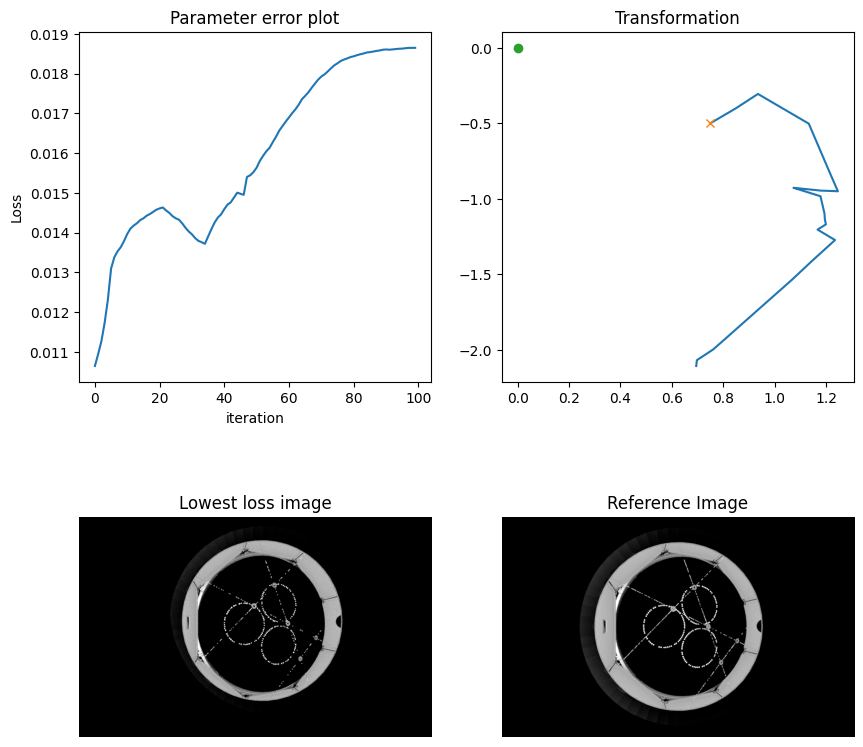

In [19]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].plot(loss_hist)
axs[0][0].set_xlabel('iteration')
axs[0][0].set_ylabel('Loss')
axs[0][0].set_title('Parameter error plot')

# axs[0][1].imshow(mi.util.convert_to_bitmap(image_init))
# axs[0][1].axis('off')
# axs[0][1].set_title('Initial Image')
posn_hist = np.array(posn_hist).reshape((iterations, 2))
axs[0][1].plot(posn_hist[:,0], posn_hist[:,1], '-') # path of optimization
axs[0][1].plot(posn_hist[0,0], posn_hist[0,1], 'x') # place marker at starting location
axs[0][1].plot(0, 0, 'o') # place a marker at target location
axs[0][1].set_title('Transformation')


# axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=spp)[:,:,0]**exp))
axs[1][0].imshow(mi.util.convert_to_bitmap(lowest_loss_render))
axs[1][0].axis('off')
# axs[1][0].set_title('Optimized image')
axs[1][0].set_title('Lowest loss image')

axs[1][1].imshow(mi.util.convert_to_bitmap(image_ref))
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image')

print("Distance to target: ", np.linalg.norm(np.array([posn_hist[-1,0], posn_hist[-1,1]])))

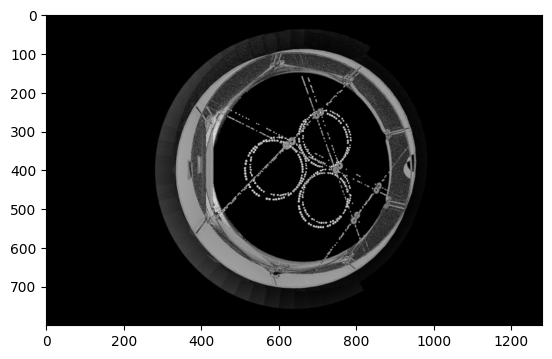

In [20]:
# plt.imshow(np.abs(mi.render(scene, spp=spp)[:,:,0] - image_ref)**exp, cmap='gray')
plt.imshow(np.abs(lowest_loss_render - image_ref)**exp, cmap='gray')